In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
table = read_csv('/content/drive/MyDrive/Quadranti.csv')
table.head()

,Unnamed: 0,Date,Ammonia,PM10,PM25,Wind_speed,Temperature,Rainfall,Quadrante
0,0,2014-01-01T00:00:00Z,0.0,6.0,7.0,0.443554,-0.334965,0.0,2
1,1,2014-01-02T00:00:00Z,0.0,6.0,5.0,0.355915,-0.486111,7.8,2
2,2,2014-01-03T00:00:00Z,0.0,11.0,4.0,0.207631,2.220588,0.0,2
3,3,2014-01-04T00:00:00Z,0.0,6.0,7.0,1.024926,2.137063,35.8,2
4,4,2014-01-05T00:00:00Z,0.0,3.0,8.0,0.666721,2.416084,25.0,2


In [4]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
Moggio = table.loc[:,["Date","PM10","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


,index,Date,PM10,Wind_speed,Quadrante,Temperature,Rainfall
0,0,2014-01-01T00:00:00Z,6.0,0.443554,2,-0.334965,0.0
1,1,2014-01-02T00:00:00Z,6.0,0.355915,2,-0.486111,7.8
2,2,2014-01-03T00:00:00Z,11.0,0.207631,2,2.220588,0.0
3,3,2014-01-04T00:00:00Z,6.0,1.024926,2,2.137063,35.8
4,4,2014-01-05T00:00:00Z,3.0,0.666721,2,2.416084,25.0


In [5]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [6]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [7]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[26,27,28,29]], axis=1, inplace=True)

print(reframed.shape)
reframed.head()

(1970, 26)


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
5,0.066667,0.163005,0.333333,0.286365,0.000000,0.066667,0.130139,0.333333,0.282413,0.035199,0.122222,0.074531,0.333333,0.353183,0.000000,0.066667,0.381024,0.333333,0.350999,0.161552,0.033333,0.246694,0.333333,0.358295,0.112816,0.022222
6,0.066667,0.130139,0.333333,0.282413,0.035199,0.122222,0.074531,0.333333,0.353183,0.000000,0.066667,0.381024,0.333333,0.350999,0.161552,0.033333,0.246694,0.333333,0.358295,0.112816,0.022222,0.075776,0.000000,0.406390,0.000000,0.077778
7,0.122222,0.074531,0.333333,0.353183,0.000000,0.066667,0.381024,0.333333,0.350999,0.161552,0.033333,0.246694,0.333333,0.358295,0.112816,0.022222,0.075776,0.000000,0.406390,0.000000,0.077778,0.034263,0.000000,0.397825,0.000000,0.044444
8,0.066667,0.381024,0.333333,0.350999,0.161552,0.033333,0.246694,0.333333,0.358295,0.112816,0.022222,0.075776,0.000000,0.406390,0.000000,0.077778,0.034263,0.000000,0.397825,0.000000,0.044444,0.201140,0.333333,0.408315,0.000000,0.044444
9,0.033333,0.246694,0.333333,0.358295,0.112816,0.022222,0.075776,0.000000,0.406390,0.000000,0.077778,0.034263,0.000000,0.397825,0.000000,0.044444,0.201140,0.333333,0.408315,0.000000,0.044444,0.063516,0.000000,0.392536,0.000000,0.133333


In [8]:
# split into train and test sets
values = reframed.values
n_features = 5 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 25) 1312 (1312,)
(1312, 5, 5) (1312,) (658, 5, 5) (658,)


# Modeling and training

Epoch 1/500
14/14 - 7s - loss: 0.1100 - val_loss: 0.0892 - 7s/epoch - 481ms/step
Epoch 2/500
14/14 - 0s - loss: 0.0975 - val_loss: 0.0866 - 232ms/epoch - 17ms/step
Epoch 3/500
14/14 - 0s - loss: 0.0938 - val_loss: 0.0864 - 227ms/epoch - 16ms/step
Epoch 4/500
14/14 - 0s - loss: 0.0935 - val_loss: 0.0858 - 235ms/epoch - 17ms/step
Epoch 5/500
14/14 - 0s - loss: 0.0923 - val_loss: 0.0853 - 236ms/epoch - 17ms/step
Epoch 6/500
14/14 - 0s - loss: 0.0917 - val_loss: 0.0853 - 235ms/epoch - 17ms/step
Epoch 7/500
14/14 - 0s - loss: 0.0912 - val_loss: 0.0851 - 229ms/epoch - 16ms/step
Epoch 8/500
14/14 - 0s - loss: 0.0909 - val_loss: 0.0847 - 226ms/epoch - 16ms/step
Epoch 9/500
14/14 - 0s - loss: 0.0906 - val_loss: 0.0843 - 241ms/epoch - 17ms/step
Epoch 10/500
14/14 - 0s - loss: 0.0903 - val_loss: 0.0840 - 242ms/epoch - 17ms/step
Epoch 11/500
14/14 - 0s - loss: 0.0900 - val_loss: 0.0836 - 227ms/epoch - 16ms/step
Epoch 12/500
14/14 - 0s - loss: 0.0897 - val_loss: 0.0832 - 230ms/epoch - 16ms/step
Epo

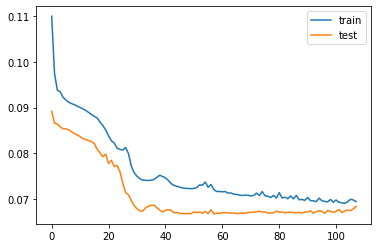

In [9]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=50, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

In [10]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
n_features = 5
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.020


#### Prediciton plots

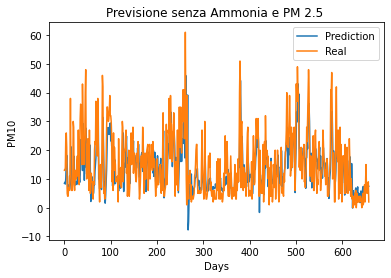

In [11]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.title("Previsione senza Ammonia e PM 2.5 ")
pyplot.xlabel('Days') 
pyplot.ylabel('PM10') 
pyplot.show()

prediction with 2020

In [12]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]

Moggio = table.loc[:,["Date","PM10","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!!
Moggio.head()
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[26,27,28,29]], axis=1, inplace=True)


# split into train and test sets
values = reframed.values
n_features = 5 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 25) 1312 (1312,)
(1312, 5, 5) (1312,) (1023, 5, 5) (1023,)


In [13]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.532


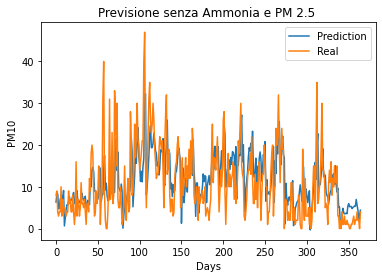

In [14]:
pyplot.plot(inv_yhat[-365:], label = 'Prediction')
pyplot.plot(inv_y[-365:], label = 'Real')
pyplot.legend()
pyplot.title("Previsione senza Ammonia e PM 2.5 ")
pyplot.xlabel('Days') 
pyplot.ylabel('PM10') 
pyplot.show()